# Исследование тарифных планов оператора сотовой связи
Компания «Мегалайн» — федеральный оператор сотовой связи. Клиентам предлагают два тарифных плана: «Смарт» и «Ультра». Чтобы скорректировать рекламный бюджет, коммерческий департамент хочет понять, какой тариф приносит больше денег.
Необходимо сделать предварительный анализ тарифов на небольшой выборке клиентов. В распоряжении данные 500 пользователей «Мегалайна»: кто они, откуда, каким тарифом пользуются, сколько звонков и сообщений каждый отправил за 2018 год. Нужно проанализировать поведение клиентов и сделать вывод — какой тариф лучше.

## Описание тарифов
**Тариф «Смарт»**
 1. Ежемесячная плата: 550 рублей
 2. Включено 500 минут разговора, 50 сообщений и 15 Гб интернет-трафика
 3. Стоимость услуг сверх тарифного пакета:
* минута разговора: 3 рубля
* сообщение: 3 рубля
* 1 Гб интернет-трафика: 200 рублей

**Тариф «Ультра»**
 1. Ежемесячная плата: 1950 рублей
 2. Включено 3000 минут разговора, 1000 сообщений и 30 Гб интернет-трафика
 3. Стоимость услуг сверх тарифного пакета:
* минута разговора: 1 рубль
* сообщение: 1 рубль
* 1 Гб интернет-трафика: 150 рублей

**Примечание:**
«Мегалайн» всегда округляет секунды до минут, а мегабайты — до гигабайт. Каждый звонок округляется отдельно: даже если он длился всего 1 секунду, будет засчитан как 1 минута.
Для веб-трафика отдельные сессии не считаются. Вместо этого общая сумма за месяц округляется в бо́льшую сторону. Если абонент использует 1025 мегабайт в этом месяце, с него возьмут плату за 2 гигабайта.

## Изучение данных из файлов

### Открытие файлов

In [1]:
# Импорт необходимых библиотек
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as st

# Открытие файла с использованием конструкции try-except
try:
    calls = pd.read_csv('C:/Users/ADMIN/Downloads/04_Анализ тарифов/datasets/calls.csv') # Локальный путь
    internet = pd.read_csv('C:/Users/ADMIN/Downloads/04_Анализ тарифов/datasets/internet.csv') # Локальный путь
    messages = pd.read_csv('C:/Users/ADMIN/Downloads/04_Анализ тарифов/datasets/messages.csv') # Локальный путь
    tariffs = pd.read_csv('C:/Users/ADMIN/Downloads/04_Анализ тарифов/datasets/tariffs.csv') # Локальный путь
    users = pd.read_csv('C:/Users/ADMIN/Downloads/04_Анализ тарифов/datasets/users.csv') # Локальный путь
except:
    calls = pd.read_csv('/datasets/calls.csv') # Серверный путь
    internet = pd.read_csv('/datasets/internet.csv') # Серверный путь
    messages = pd.read_csv('/datasets/messages.csv') # Серверный путь
    tariffs = pd.read_csv('/datasets/tariffs.csv') # Серверный путь
    users = pd.read_csv('/datasets/users.csv') # Серверный путь

# Снятие ограничений на отражение максимального коливества столбцов
pd.set_option('display.max_columns', None)

# Получение первых строк таблицы users
users.head()

,user_id,age,churn_date,city,first_name,last_name,reg_date,tariff
0,1000,52,NaN,Краснодар,Рафаил,Верещагин,2018-05-25,ultra
1,1001,41,NaN,Москва,Иван,Ежов,2018-11-01,smart
2,1002,59,NaN,Стерлитамак,Евгений,Абрамович,2018-06-17,smart
3,1003,23,NaN,Москва,Белла,Белякова,2018-08-17,ultra
4,1004,68,NaN,Новокузнецк,Татьяна,Авдеенко,2018-05-14,ultra


In [2]:
# Получение первых строк таблицы calls
calls.head()

,id,call_date,duration,user_id
0,1000_0,2018-07-25,0.00,1000
1,1000_1,2018-08-17,0.00,1000
2,1000_2,2018-06-11,2.85,1000
3,1000_3,2018-09-21,13.80,1000
4,1000_4,2018-12-15,5.18,1000


In [3]:
# Получение первых строк таблицы messages
messages.head()

,id,message_date,user_id
0,1000_0,2018-06-27,1000
1,1000_1,2018-10-08,1000
2,1000_2,2018-08-04,1000
3,1000_3,2018-06-16,1000
4,1000_4,2018-12-05,1000


In [4]:
# Получение первых строк таблицы internet
internet.head()

,Unnamed: 0,id,mb_used,session_date,user_id
0,0,1000_0,112.95,2018-11-25,1000
1,1,1000_1,1052.81,2018-09-07,1000
2,2,1000_2,1197.26,2018-06-25,1000
3,3,1000_3,550.27,2018-08-22,1000
4,4,1000_4,302.56,2018-09-24,1000


In [5]:
# Получение первых строк таблицы tariffs
tariffs.head()

,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,tariff_name
0,50,15360,500,550,200,3,3,smart
1,1000,30720,3000,1950,150,1,1,ultra


### Информация о данных

#### Users (информация о пользователях)

In [6]:
# Вывод информации о users
users.info()
users.describe(include='all')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   user_id     500 non-null    int64 
 1   age         500 non-null    int64 
 2   churn_date  38 non-null     object
 3   city        500 non-null    object
 4   first_name  500 non-null    object
 5   last_name   500 non-null    object
 6   reg_date    500 non-null    object
 7   tariff      500 non-null    object
dtypes: int64(2), object(6)
memory usage: 31.4+ KB


,user_id,age,churn_date,city,first_name,last_name,reg_date,tariff
count,500.000000,500.00000,38,500,500,500,500,500
unique,NaN,NaN,33,76,246,419,270,2
top,NaN,NaN,2018-10-03,Москва,Радим,Андреенко,2018-05-28,smart
freq,NaN,NaN,2,99,6,5,8,351
mean,1249.500000,46.58800,NaN,NaN,NaN,NaN,NaN,NaN
std,144.481833,16.66763,NaN,NaN,NaN,NaN,NaN,NaN
min,1000.000000,18.00000,NaN,NaN,NaN,NaN,NaN,NaN
25%,1124.750000,32.00000,NaN,NaN,NaN,NaN,NaN,NaN
50%,1249.500000,46.00000,NaN,NaN,NaN,NaN,NaN,NaN
75%,1374.250000,62.00000,NaN,NaN,NaN,NaN,NaN,NaN


In [7]:
# Подсчёт пропусков
users.isna().sum()

user_id         0
age             0
churn_date    462
city            0
first_name      0
last_name       0
reg_date        0
tariff          0
dtype: int64

В исходных данных о пользователях 500 строк и `8 столбцов`:
* `user_id` — уникальный идентификатор пользователя **[int64] - норм**
* `age` — возраст пользователя (годы) **[int64] - норм**
* `churn_date` — дата прекращения пользования тарифом (если значение пропущено, то тариф ещё действовал на момент выгрузки данных) <font color='red'>**[object] - скорректировать на datetime**</font>
* `city` — город проживания пользователя **[object] - норм**
* `first_name` — имя пользователя **[object] - норм**
* `last_name` — фамилия пользователя **[object] - норм**
* `reg_date` — дата подключения тарифа (день, месяц, год) <font color='red'>**[object] - скорректировать на datetime**</font>
* `tariff` — название тарифного плана **[object] - норм**

#### Calls (информация о звонках)

In [8]:
# Вывод информации о calls
calls.info()
calls.describe(include='all')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 202607 entries, 0 to 202606
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   id         202607 non-null  object 
 1   call_date  202607 non-null  object 
 2   duration   202607 non-null  float64
 3   user_id    202607 non-null  int64  
dtypes: float64(1), int64(1), object(2)
memory usage: 6.2+ MB


,id,call_date,duration,user_id
count,202607,202607,202607.000000,202607.000000
unique,202607,365,NaN,NaN
top,1063_807,2018-12-31,NaN,NaN
freq,1,1435,NaN,NaN
mean,NaN,NaN,6.755887,1253.940619
std,NaN,NaN,5.843365,144.722751
min,NaN,NaN,0.000000,1000.000000
25%,NaN,NaN,1.300000,1126.000000
50%,NaN,NaN,6.000000,1260.000000
75%,NaN,NaN,10.700000,1379.000000


In [9]:
# Подсчёт пропусков
calls.isna().sum()

id           0
call_date    0
duration     0
user_id      0
dtype: int64

В исходных данных о звонках 202607 строк и `4 столбца`:
* `id` — уникальный номер звонка **[object] - норм**
* `call_date` — дата звонка <font color='red'>**[object] - скорректировать на datetime**</font>
* `duration` — длительность звонка в минутах <font color='red'>**[float64] - округлить до целых в большую сторону и скорректировать на int64**</font>
* `user_id` — идентификатор пользователя, сделавшего звонок **[int64] - норм**

#### Messages (информация о сообщениях)

In [10]:
# Вывод информации о messages
messages.info()
messages.describe(include='all')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 123036 entries, 0 to 123035
Data columns (total 3 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   id            123036 non-null  object
 1   message_date  123036 non-null  object
 2   user_id       123036 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 2.8+ MB


,id,message_date,user_id
count,123036,123036,123036.000000
unique,123036,364,NaN
top,1267_58,2018-12-31,NaN
freq,1,859,NaN
mean,NaN,NaN,1256.989410
std,NaN,NaN,143.523967
min,NaN,NaN,1000.000000
25%,NaN,NaN,1134.000000
50%,NaN,NaN,1271.000000
75%,NaN,NaN,1381.000000


In [11]:
# Подсчёт пропусков
messages.isna().sum()

id              0
message_date    0
user_id         0
dtype: int64

В исходных данных о сообщениях 123036 строк и `3 столбца`:
* `id` — уникальный номер сообщения **[object] - норм**
* `message_date` — дата сообщения <font color='red'>**[object] - скорректировать на datetime**</font>
* `user_id` — идентификатор пользователя, отправившего сообщение **[int64] - норм**

#### Internet (информация об интернет-сессиях)

In [12]:
# Вывод информации о internet
internet.info()
internet.describe(include='all')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 149396 entries, 0 to 149395
Data columns (total 5 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   Unnamed: 0    149396 non-null  int64  
 1   id            149396 non-null  object 
 2   mb_used       149396 non-null  float64
 3   session_date  149396 non-null  object 
 4   user_id       149396 non-null  int64  
dtypes: float64(1), int64(2), object(2)
memory usage: 5.7+ MB


,Unnamed: 0,id,mb_used,session_date,user_id
count,149396.000000,149396,149396.000000,149396,149396.000000
unique,NaN,149396,NaN,365,NaN
top,NaN,1458_146,NaN,2018-12-31,NaN
freq,NaN,1,NaN,1057,NaN
mean,74697.500000,NaN,370.192426,NaN,1252.099842
std,43127.054745,NaN,278.300951,NaN,144.050823
min,0.000000,NaN,0.000000,NaN,1000.000000
25%,37348.750000,NaN,138.187500,NaN,1130.000000
50%,74697.500000,NaN,348.015000,NaN,1251.000000
75%,112046.250000,NaN,559.552500,NaN,1380.000000


In [13]:
# Подсчёт пропусков
internet.isna().sum()

Unnamed: 0      0
id              0
mb_used         0
session_date    0
user_id         0
dtype: int64

В исходных данных об интернет-сессиях 149396 строк и `5 столбцов`:
* `Unnamed: 0` - дублирует index <font color='red'>**удалить столбец**</font>
* `id` — уникальный номер сессии **[object] - норм**
* `mb_used` — объём потраченного за сессию интернет-трафика (в мегабайтах) **[float64] - норм**
* `session_date` — дата интернет-сессии <font color='red'>**[object] - скорректировать на datetime**</font>
* `user_id` — идентификатор пользователя **[int64] - норм**

#### Tariffs (информация о тарифах)

In [14]:
# Вывод информации о tariffs
tariffs.info()
tariffs.describe(include='all')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2 entries, 0 to 1
Data columns (total 8 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   messages_included      2 non-null      int64 
 1   mb_per_month_included  2 non-null      int64 
 2   minutes_included       2 non-null      int64 
 3   rub_monthly_fee        2 non-null      int64 
 4   rub_per_gb             2 non-null      int64 
 5   rub_per_message        2 non-null      int64 
 6   rub_per_minute         2 non-null      int64 
 7   tariff_name            2 non-null      object
dtypes: int64(7), object(1)
memory usage: 256.0+ bytes


,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,tariff_name
count,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2
unique,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2
top,NaN,NaN,NaN,NaN,NaN,NaN,NaN,ultra
freq,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
mean,525.000000,23040.000000,1750.000000,1250.000000,175.000000,2.000000,2.000000,NaN
std,671.751442,10861.160159,1767.766953,989.949494,35.355339,1.414214,1.414214,NaN
min,50.000000,15360.000000,500.000000,550.000000,150.000000,1.000000,1.000000,NaN
25%,287.500000,19200.000000,1125.000000,900.000000,162.500000,1.500000,1.500000,NaN
50%,525.000000,23040.000000,1750.000000,1250.000000,175.000000,2.000000,2.000000,NaN
75%,762.500000,26880.000000,2375.000000,1600.000000,187.500000,2.500000,2.500000,NaN


In [15]:
# Подсчёт пропусков
tariffs.isna().sum()

messages_included        0
mb_per_month_included    0
minutes_included         0
rub_monthly_fee          0
rub_per_gb               0
rub_per_message          0
rub_per_minute           0
tariff_name              0
dtype: int64

В исходных данных о тарифах 2 строки и `8 столбцов`:
* `messages_included` — количество сообщений в месяц, включённых в абонентскую плату **[int64] - норм**
* `mb_per_month_included` — объём интернет-трафика, включённого в абонентскую плату (в мегабайтах) **[int64] - норм**
* `minutes_included` — количество минут разговора в месяц, включённых в абонентскую плату **[int64] - норм**
* `rub_monthly_fee` — ежемесячная абонентская плата в рублях **[int64] - норм**
* `rub_per_gb` — стоимость дополнительного гигабайта интернет-трафика сверх тарифного пакета (1 гигабайт = 1024 мегабайта) **[int64] - норм**
* `rub_per_message` — стоимость отправки сообщения сверх тарифного пакета **[int64] - норм**
* `rub_per_minute` — стоимость минуты разговора сверх тарифного пакета (например, если в тарифе 100 минут разговора в месяц, то со 101 минуты будет взиматься плата) **[int64] - норм**
* `tariff_name` — название тарифа **[object] - норм**

### Вывод

В источнике данных с информацией об интернет-сессиях есть **столбец дублирующий индексацию** `Unnamed: 0`, в предобработке данных он будет исключен, но при последующих выгрузках желательно сохранять файлы с данными без индекса, используя `index=False`.

Есть **несоответствия в типах данных** (см.выше красным шрифтом): churn_date, reg_date, call_date, duration, message_date, session_date.

**Пропусков значений нет**, за исключением столбца `churn_date` в данных с информацией о пользователях (если значение пропущено, то тариф ещё действовал на момент выгрузки данных).

## Предобработка данных

Приведите данные к нужным типам;

Найдите и исправьте ошибки в данных, если они есть.

Поясните, какие ошибки вы нашли и как их исправили. В данных вы найдёте звонки с нулевой продолжительностью. Это не ошибка: нулями обозначены пропущенные звонки, поэтому их не нужно удалять.


### Users (информация о пользователях)

#### user_id

In [16]:
# Количество уникальных значений:
users['user_id'].nunique()

500

Замечаний нет (аномальные/отрицательные значения отсутсвуют, тип данных соответствует, пропусков и повторов нет).

#### age

In [17]:
# Уникальные значения:
users['age'].sort_values().unique()

array([18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34,
       35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51,
       52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68,
       69, 70, 71, 72, 73, 74, 75])

Замечаний нет (аномальные/отрицательные значения отсутсвуют, тип данных соответствует, пропусков нет, минимальные/максимальные значения не вызывают сомнений).

#### churn_date

In [18]:
# Изменение типа данных
users['churn_date'] = pd.to_datetime(users['churn_date'], format='%Y-%m-%d')

# Округление до 1 дня
users['churn_date'] = users['churn_date'].dt.round('1D')

# Проверка аномальных значений
users['churn_date'].describe(datetime_is_numeric=True)

count                               38
mean     2018-11-13 00:37:53.684210432
min                2018-08-17 00:00:00
25%                2018-10-14 00:00:00
50%                2018-11-24 00:00:00
75%                2018-12-15 12:00:00
max                2018-12-30 00:00:00
Name: churn_date, dtype: object

Крайние даты: 2018-08-17 и 2018-12-30. Аномальные значения отсутствуют.

#### city

In [19]:
# Уникальные значения:
users['city'].sort_values().unique()

array(['Архангельск', 'Астрахань', 'Балашиха', 'Барнаул', 'Белгород',
       'Брянск', 'Владивосток', 'Владикавказ', 'Владимир', 'Волгоград',
       'Волжский', 'Вологда', 'Воронеж', 'Грозный', 'Екатеринбург',
       'Иваново', 'Ижевск', 'Иркутск', 'Казань', 'Калининград', 'Калуга',
       'Кемерово', 'Киров', 'Кострома', 'Краснодар', 'Красноярск',
       'Курган', 'Курск', 'Липецк', 'Магнитогорск', 'Махачкала', 'Москва',
       'Мурманск', 'Набережные Челны', 'Нижневартовск', 'Нижний Новгород',
       'Нижний Тагил', 'Новокузнецк', 'Новороссийск', 'Новосибирск',
       'Омск', 'Оренбург', 'Орёл', 'Пенза', 'Пермь', 'Петрозаводск',
       'Подольск', 'Ростов-на-Дону', 'Рязань', 'Самара',
       'Санкт-Петербург', 'Саранск', 'Саратов', 'Севастополь', 'Смоленск',
       'Сочи', 'Ставрополь', 'Стерлитамак', 'Сургут', 'Тамбов', 'Тверь',
       'Тольятти', 'Томск', 'Тула', 'Тюмень', 'Улан-Удэ', 'Ульяновск',
       'Уфа', 'Хабаровск', 'Химки', 'Чебоксары', 'Челябинск', 'Череповец',
       'Чи

В уникальных значениях наблюдается единство стиля. Неявные дубликаты и пропуски отсутствуют.

#### first_name

In [20]:
# Уникальные значения:
users['first_name'].sort_values().unique()

array(['Авксентий', 'Агата', 'Агафья', 'Агнесса', 'Адам', 'Аким', 'Аксён',
       'Алан', 'Алевтина', 'Александр', 'Александра', 'Алексей', 'Алина',
       'Алиса', 'Алла', 'Альберта', 'Альбин', 'Альфред', 'Алёна',
       'Анатолий', 'Анвар', 'Ангелина', 'Андрей', 'Анжелика', 'Анита',
       'Антонина', 'Анфиса', 'Арина', 'Арнольд', 'Арсен', 'Арсений',
       'Артемий', 'Артём', 'Аурелия', 'Афанасий', 'Ахмет', 'Аюна',
       'Белла', 'Берта', 'Борис', 'Вадим', 'Валентина', 'Валерий',
       'Валерия', 'Варвара', 'Варлам', 'Василиса', 'Вениамин', 'Вера',
       'Вероника', 'Веселина', 'Виктор', 'Виктория', 'Виолетта',
       'Виталий', 'Владимир', 'Владислав', 'Владислава', 'Всеволод',
       'Габриель', 'Габриэль', 'Гайдар', 'Галина', 'Гарри', 'Гектор',
       'Гелена', 'Геннадий', 'Геодар', 'Георгий', 'Георгина', 'Геральд',
       'Герасим', 'Глеб', 'Гордей', 'Григорий', 'Дайна', 'Дана', 'Даниил',
       'Даниэла', 'Дебора', 'Демьян', 'Денис', 'Джемма', 'Джозефина',
       'Джулия', '

В уникальных значениях наблюдается единство стиля. Аномальные значения и пропуски отсутствуют.

#### last_name

In [21]:
# Уникальные значения:
users['last_name'].sort_values().unique()

array(['Ёлчина', 'Ёркин', 'Ёркина', 'Ёрохов', 'Ёрохова', 'Абаимов',
       'Абакумов', 'Абакшина', 'Абалакова', 'Абалдуева', 'Абалкин',
       'Абашкин', 'Абашкина', 'Абдулина', 'Абоимов', 'Абрамович',
       'Абрамцев', 'Абрамычева', 'Абрашина', 'Абрикосова', 'Авдеев',
       'Авдеенко', 'Авдонюшкин', 'Авдушева', 'Авдышев', 'Авдюков',
       'Авраамова', 'Авраменко', 'Авринский', 'Аврорин', 'Авроров',
       'Авросимова', 'Авросинова', 'Авсейкина', 'Авчинникова', 'Агаев',
       'Агаева', 'Агапеева', 'Агеева', 'Адаменко', 'Адамов', 'Азаров',
       'Азерников', 'Азимова', 'Акимов', 'Акимчин', 'Акимычева',
       'Акиндинов', 'Акинин', 'Акинфьев', 'Аксёнов', 'Акуленко',
       'Александрова', 'Александрович', 'Александрюк', 'Алексеева',
       'Алексеенко', 'Алексеичев', 'Аленникова', 'Алесин', 'Алехина',
       'Алешин', 'Алешина', 'Алешкова', 'Алиев', 'Алфеева', 'Алфимов',
       'Алфимова', 'Алымова', 'Алютин', 'Алюшина', 'Алёшко', 'Алёшкова',
       'Амелин', 'Амелишко', 'Амельченк

В уникальных значениях наблюдается единство стиля. Аномальные значения и пропуски отсутствуют.

#### reg_date

In [22]:
# Изменение типа данных
users['reg_date'] = pd.to_datetime(users['reg_date'], format='%Y-%m-%d')

# Округление до 1 дня
users['reg_date'] = users['reg_date'].dt.round('1D')

# Проверка аномальных значений
users['reg_date'].describe(datetime_is_numeric=True)

count                              500
mean     2018-06-30 18:57:35.999999744
min                2018-01-01 00:00:00
25%                2018-04-07 12:00:00
50%                2018-07-02 12:00:00
75%                2018-09-29 00:00:00
max                2018-12-31 00:00:00
Name: reg_date, dtype: object

Крайние даты: 2018-01-01 и 2018-12-31. Аномальные значения отсутствуют.

#### tariff

In [23]:
# Уникальные значения:
users['tariff'].sort_values().unique()

array(['smart', 'ultra'], dtype=object)

Замечаний нет (аномальные/отрицательные значения отсутсвуют, тип данных соответствует, пропусков и повторов нет).

### Calls (информация о звонках)

#### id

In [24]:
# Количество уникальных значений:
calls['id'].nunique()

202607

Замечаний нет (аномальные/отрицательные значения отсутсвуют, тип данных соответствует, пропусков и повторов нет).

Логика записи данных: `user_id`_`порядковый номер звонка`.

#### call_date

In [25]:
# Изменение типа данных
calls['call_date'] = pd.to_datetime(calls['call_date'], format='%Y-%m-%d')

# Округление до 1 дня
calls['call_date'] = calls['call_date'].dt.round('1D')

# Проверка аномальных значений
calls['call_date'].describe(datetime_is_numeric=True)

count                           202607
mean     2018-09-02 20:01:37.583992832
min                2018-01-01 00:00:00
25%                2018-07-05 00:00:00
50%                2018-09-17 00:00:00
75%                2018-11-14 00:00:00
max                2018-12-31 00:00:00
Name: call_date, dtype: object

Крайние даты: 2018-01-01 и 2018-12-31. Аномальные значения отсутствуют.

#### duration

In [26]:
# Уникальные значения:
calls['duration'].sort_values().unique()

array([0.000e+00, 1.000e-02, 2.000e-02, ..., 3.647e+01, 3.735e+01,
       3.800e+01])

In [27]:
# Округление до целого в большую сторону в соответствии с примечанием к тарифам + изменение типа
calls['duration'] = np.ceil(calls.duration).astype(int)

Замечаний нет (аномальные/отрицательные значения отсутсвуют, тип данных соответствует, пропусков нет).

#### user_id

In [28]:
# Количество уникальных значений:
calls['user_id'].nunique()

492

Замечаний нет (аномальные/отрицательные значения отсутсвуют, тип данных соответствует, пропусков нет).

### Messages (информация о сообщениях)

#### id

In [29]:
# Количество уникальных значений:
messages['id'].nunique()

123036

Замечаний нет (аномальные/отрицательные значения отсутсвуют, тип данных соответствует, пропусков и повторов нет).

Логика записи данных: `user_id`_`порядковый номер сообщения`.

#### message_date

In [30]:
# Изменение типа данных
messages['message_date'] = pd.to_datetime(messages['message_date'], format='%Y-%m-%d')

# Округление до 1 дня
messages['message_date'] = messages['message_date'].dt.round('1D')

# Проверка аномальных значений
messages['message_date'].describe(datetime_is_numeric=True)

count                           123036
mean     2018-09-04 15:28:42.227640576
min                2018-01-02 00:00:00
25%                2018-07-09 00:00:00
50%                2018-09-20 00:00:00
75%                2018-11-14 00:00:00
max                2018-12-31 00:00:00
Name: message_date, dtype: object

Крайние даты: 2018-01-02 и 2018-12-31. Аномальные значения отсутствуют.

#### user_id

In [31]:
# Количество уникальных значений:
messages['user_id'].nunique()

426

Замечаний нет (аномальные/отрицательные значения отсутсвуют, тип данных соответствует, пропусков нет).

### Internet (информация об интернет-сессиях)

#### Unnamed: 0

In [32]:
# Удаление столбца 'Unnamed: 0'
internet.drop(['Unnamed: 0'], axis=1, inplace=True)

#### id

In [33]:
# Количество уникальных значений:
internet['id'].nunique()

149396

Замечаний нет (аномальные/отрицательные значения отсутсвуют, тип данных соответствует, пропусков и повторов нет).

Логика записи данных: `user_id`_`порядковый номер сообщения`.

#### mb_used

In [34]:
# Уникальные значения:
internet['mb_used'].sort_values().unique()

array([0.00000e+00, 3.00000e-02, 4.00000e-02, ..., 1.65155e+03,
       1.70275e+03, 1.72483e+03])

Замечаний нет (аномальные/отрицательные значения отсутсвуют, тип данных соответствует, пропусков нет).

#### session_date

In [35]:
# Изменение типа данных
internet['session_date'] = pd.to_datetime(internet['session_date'], format='%Y-%m-%d')

# Округление до 1 дня
internet['session_date'] = internet['session_date'].dt.round('1D')

# Проверка аномальных значений
internet['session_date'].describe(datetime_is_numeric=True)

count                           149396
mean     2018-09-02 12:55:35.221826560
min                2018-01-01 00:00:00
25%                2018-07-05 00:00:00
50%                2018-09-17 00:00:00
75%                2018-11-14 00:00:00
max                2018-12-31 00:00:00
Name: session_date, dtype: object

Крайние даты: 2018-01-01 и 2018-12-31. Аномальные значения отсутствуют.

#### user_id

In [36]:
# Количество уникальных значений:
internet['user_id'].nunique()

497

Замечаний нет (аномальные/отрицательные значения отсутсвуют, тип данных соответствует, пропусков нет).

### Tariffs (информация о тарифах)

#### mb_per_month_included

In [37]:
# Уникальные значения:
tariffs['mb_per_month_included'].sort_values().unique()

array([15360, 30720])

Замечаний нет (аномальные/отрицательные значения отсутсвуют, тип данных соответствует, пропусков нет).

#### minutes_included

In [38]:
# Уникальные значения:
tariffs['minutes_included'].sort_values().unique()

array([ 500, 3000])

Замечаний нет (аномальные/отрицательные значения отсутсвуют, тип данных соответствует, пропусков нет).

#### rub_monthly_fee

In [39]:
# Уникальные значения:
tariffs['rub_monthly_fee'].sort_values().unique()

array([ 550, 1950])

Замечаний нет (аномальные/отрицательные значения отсутсвуют, тип данных соответствует, пропусков нет).

#### rub_per_gb 

In [40]:
# Уникальные значения:
tariffs['rub_per_gb'].sort_values().unique()

array([150, 200])

Замечаний нет (аномальные/отрицательные значения отсутсвуют, тип данных соответствует, пропусков нет).

#### rub_per_message

In [41]:
# Уникальные значения:
tariffs['rub_per_message'].sort_values().unique()

array([1, 3])

Замечаний нет (аномальные/отрицательные значения отсутсвуют, тип данных соответствует, пропусков нет).

#### rub_per_minute 

In [42]:
# Уникальные значения:
tariffs['rub_per_minute'].sort_values().unique()

array([1, 3])

Замечаний нет (аномальные/отрицательные значения отсутсвуют, тип данных соответствует, пропусков нет).

#### tariff_name

In [43]:
# Уникальные значения:
tariffs['tariff_name'].sort_values().unique()

# Переименование столбца для последующего объединения данных
tariffs = tariffs.rename(columns={'tariff_name': 'tariff'})

tariffs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2 entries, 0 to 1
Data columns (total 8 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   messages_included      2 non-null      int64 
 1   mb_per_month_included  2 non-null      int64 
 2   minutes_included       2 non-null      int64 
 3   rub_monthly_fee        2 non-null      int64 
 4   rub_per_gb             2 non-null      int64 
 5   rub_per_message        2 non-null      int64 
 6   rub_per_minute         2 non-null      int64 
 7   tariff                 2 non-null      object
dtypes: int64(7), object(1)
memory usage: 256.0+ bytes


Замечаний нет (аномальные/отрицательные значения отсутсвуют, тип данных соответствует, пропусков нет).

### Итоговая проверка

In [44]:
# Вывод информации о users
users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   user_id     500 non-null    int64         
 1   age         500 non-null    int64         
 2   churn_date  38 non-null     datetime64[ns]
 3   city        500 non-null    object        
 4   first_name  500 non-null    object        
 5   last_name   500 non-null    object        
 6   reg_date    500 non-null    datetime64[ns]
 7   tariff      500 non-null    object        
dtypes: datetime64[ns](2), int64(2), object(4)
memory usage: 31.4+ KB


In [45]:
# Вывод информации о calls
calls.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 202607 entries, 0 to 202606
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype         
---  ------     --------------   -----         
 0   id         202607 non-null  object        
 1   call_date  202607 non-null  datetime64[ns]
 2   duration   202607 non-null  int64         
 3   user_id    202607 non-null  int64         
dtypes: datetime64[ns](1), int64(2), object(1)
memory usage: 6.2+ MB


In [46]:
# Вывод информации о messages
messages.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 123036 entries, 0 to 123035
Data columns (total 3 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   id            123036 non-null  object        
 1   message_date  123036 non-null  datetime64[ns]
 2   user_id       123036 non-null  int64         
dtypes: datetime64[ns](1), int64(1), object(1)
memory usage: 2.8+ MB


In [47]:
# Вывод информации о internet
internet.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 149396 entries, 0 to 149395
Data columns (total 4 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   id            149396 non-null  object        
 1   mb_used       149396 non-null  float64       
 2   session_date  149396 non-null  datetime64[ns]
 3   user_id       149396 non-null  int64         
dtypes: datetime64[ns](1), float64(1), int64(1), object(1)
memory usage: 4.6+ MB


In [48]:
# Вывод информации о tariffs
tariffs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2 entries, 0 to 1
Data columns (total 8 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   messages_included      2 non-null      int64 
 1   mb_per_month_included  2 non-null      int64 
 2   minutes_included       2 non-null      int64 
 3   rub_monthly_fee        2 non-null      int64 
 4   rub_per_gb             2 non-null      int64 
 5   rub_per_message        2 non-null      int64 
 6   rub_per_minute         2 non-null      int64 
 7   tariff                 2 non-null      object
dtypes: int64(7), object(1)
memory usage: 256.0+ bytes


In [49]:
# Подсчёт явных дубликатов users
users.duplicated().sum()

0

In [50]:
# Подсчёт явных дубликатов calls
calls.duplicated().sum()

0

In [51]:
# Подсчёт явных дубликатов messages
messages.duplicated().sum()

0

In [52]:
# Подсчёт явных дубликатов internet
internet.duplicated().sum()

0

In [53]:
# Подсчёт явных дубликатов tariffs
tariffs.duplicated().sum()

0

## Расчёты и добавление результатов в таблицу

### Количество сделанных звонков и израсходованных минут разговора по месяцам

In [54]:
# Добавление столбца с номером месяца
calls['month'] = calls['call_date'].dt.month

# Создание сгруппированного датафрейма
calls_grouped = calls.groupby(['user_id', 'month'], as_index=False).agg({'duration': ['sum','count']})

# Переимнование столбцов для исключения двойной индексации
calls_grouped.columns = ['user_id', 'month', 'calls_time', 'calls_amount']

# Проверка
calls_grouped.head()

,user_id,month,calls_time,calls_amount
0,1000,5,159,22
1,1000,6,172,43
2,1000,7,340,47
3,1000,8,408,52
4,1000,9,466,58


### Количество отправленных сообщений по месяцам

In [55]:
# Добавление столбца с номером месяца
messages['month'] = messages['message_date'].dt.month

# Создание сгруппированного датафрейма и переименование столбца
messages_grouped = messages.groupby(['user_id', 'month'], as_index=False).agg({'message_date': 'count'}).rename(columns={'message_date':'message_amount'})

# Проверка
messages_grouped.head()

,user_id,month,message_amount
0,1000,5,22
1,1000,6,60
2,1000,7,75
3,1000,8,81
4,1000,9,57


### Объем израсходованного интернет-трафика по месяцам

In [56]:
# Добавление столбца с номером месяца
internet['month'] = internet['session_date'].dt.month

# Создание сгруппированного датафрейма и переименование столбца
internet_grouped = internet.groupby(['user_id', 'month'], as_index=False).agg({'mb_used': 'sum'}).rename(columns={'mb_used':'mb_used_month'})

# Проверка
internet_grouped.head()

,user_id,month,mb_used_month
0,1000,5,2253.49
1,1000,6,23233.77
2,1000,7,14003.64
3,1000,8,14055.93
4,1000,9,14568.91


### Помесячная выручка с каждого пользователя (revenue)

In [57]:
# Добавление столбца с месяцем в данные о пользователях
users['month'] = ''

# Формирование датафрейма на основе имеющейся информации
df = pd.DataFrame()
index = 0
for i in range(len(users)): # повтор для каждой строки в датафрейме
    for j in range(1, 12+1): # сколько строк необходимо вставить (12 месяцев)
        row = users.iloc[i] # выделяем строку из исходного датафрейма
        df = df.append(row,ignore_index=True) # добавляем в новый датафрейм
        df.at[index, 'month'] = j # присваиваем месяц
        index+=1 # сдвигаем счетчик

# Восстановление расположения столбцов в соответствии с users
df = df.reindex(columns=['user_id', 'age', 'churn_date', 'city', 'first_name', 'last_name', 'reg_date', 'tariff', 'month'])

# Изменение типа данных
df['user_id'] = df['user_id'].astype('int64')
df['age'] = df['age'].astype('int64')
df['month'] = df['month'].astype('int64')

# Добавление информации о звонках, сообщениях, интернете, тарифе
df = df.merge(tariffs, on='tariff', how='left')
df = df.merge(calls_grouped, on=['user_id', 'month'], how='left')
df = df.merge(messages_grouped, on=['user_id', 'month'], how='left')
df = df.merge(internet_grouped, on=['user_id', 'month'], how='left')

# Заполнение пропусков нулевыми значениями
df['calls_time'] = df['calls_time'].fillna(0)
df['calls_amount'] = df['calls_amount'].fillna(0)
df['message_amount'] = df['message_amount'].fillna(0)
df['mb_used_month'] = df['mb_used_month'].fillna(0)

# Изменение типа данных
df['calls_time'] = df['calls_time'].astype('int64')
df['calls_amount'] = df['calls_amount'].astype('int64')
df['message_amount'] = df['message_amount'].astype('int64')

# Вычитание бесплатного лимита из суммарного количетсва звонков, сообщений и интернет-трафика
df['over_limit_calls'] = df['calls_time'] - df['minutes_included']
df['over_limit_message'] = df['message_amount'] - df['messages_included']
df['over_limit_gb'] = (df['mb_used_month'] - df['mb_per_month_included']) / 1024

# Исключение отрицательных значений
df.loc[df['over_limit_calls']<0, 'over_limit_calls'] = 0
df.loc[df['over_limit_message']<0, 'over_limit_message'] = 0
df.loc[df['over_limit_gb']<0, 'over_limit_gb'] = 0

# Округление трафика до Гб в большую сторону и корреткировка типа данных
df['over_limit_gb'] = np.ceil(df.over_limit_gb).astype(int)

# Создание столбца с коэффициентом 0 / 1 для месяцев после начала регистрации
df['reg_on'] = df['month'] - df['reg_date'].dt.month # вычитание месяца подключения
df.loc[df['reg_on']>=0, 'reg_on'] = 1 # 0  и положиельные значения - тариф подключен
df.loc[df['reg_on']<0, 'reg_on'] = 0 # отрицательные значения - тариф не подключен

# Создание столбца с коэффициентом 0 / 1 для месяцев до окончания регистрации
df['churn_off'] = df['churn_date'].dt.month - df['month']
df['churn_off'] = df['churn_off'].fillna(1)
df.loc[df['churn_off']>=0, 'churn_off'] = 1 # 0  и положиельные значения - тариф подключен
df.loc[df['churn_off']<0, 'churn_off'] = 0 # отрицательные значения - тариф не подключен

# Расчет выручки
df['revenue'] = (df['over_limit_calls'] * df['rub_per_minute']
                 + df['over_limit_message'] * df['rub_per_message']
                 + df['over_limit_gb'] * df['rub_per_gb']
                 + df['rub_monthly_fee']
                ) * df['reg_on'] * df['churn_off']

# Проверка
df.info()
df.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6000 entries, 0 to 5999
Data columns (total 26 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   user_id                6000 non-null   int64         
 1   age                    6000 non-null   int64         
 2   churn_date             456 non-null    datetime64[ns]
 3   city                   6000 non-null   object        
 4   first_name             6000 non-null   object        
 5   last_name              6000 non-null   object        
 6   reg_date               6000 non-null   datetime64[ns]
 7   tariff                 6000 non-null   object        
 8   month                  6000 non-null   int64         
 9   messages_included      6000 non-null   int64         
 10  mb_per_month_included  6000 non-null   int64         
 11  minutes_included       6000 non-null   int64         
 12  rub_monthly_fee        6000 non-null   int64         
 13  rub

,user_id,age,churn_date,city,first_name,last_name,reg_date,tariff,month,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,calls_time,calls_amount,message_amount,mb_used_month,over_limit_calls,over_limit_message,over_limit_gb,reg_on,churn_off,revenue
0,1000,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,1,1000,30720,3000,1950,150,1,1,0,0,0,0.00,0,0,0,0,1.0,0.0
1,1000,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,2,1000,30720,3000,1950,150,1,1,0,0,0,0.00,0,0,0,0,1.0,0.0
2,1000,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,3,1000,30720,3000,1950,150,1,1,0,0,0,0.00,0,0,0,0,1.0,0.0
3,1000,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,4,1000,30720,3000,1950,150,1,1,0,0,0,0.00,0,0,0,0,1.0,0.0
4,1000,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,5,1000,30720,3000,1950,150,1,1,159,22,22,2253.49,0,0,0,1,1.0,1950.0


## Исследовательский анализ данных

Опишите поведение клиентов оператора, исходя из выборки. Сколько минут разговора, сколько сообщений и какой объём интернет-трафика требуется пользователям каждого тарифа в месяц? Посчитайте среднее количество, дисперсию и стандартное отклонение. Постройте гистограммы. Опишите распределения.

### Тариф smart

In [58]:
# Срез df по тарифу smart и наличию выручки
smart = df.query('tariff == "smart" and revenue > 0')

#### Минуты разговора

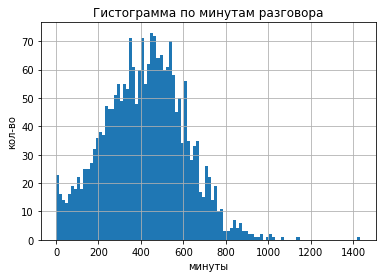

In [59]:
# Построение гистограммы по минутам разговора
smart['calls_time'].hist(bins=100)
plt.title('Гистограмма по минутам разговора')
plt.xlabel('минуты')
plt.ylabel('кол-во')
plt.show()

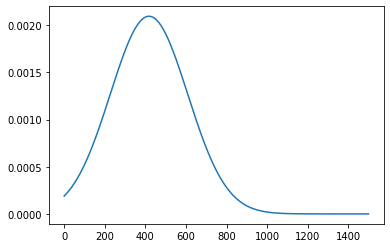

In [60]:
# Среднее количество минут разговора
smart_calls_mean = smart['calls_time'].mean()

# Расчет дисперсии по выборке
variance_smart_calls = np.var(smart['calls_time'], ddof=1)

# Стандартное отклонение равно квадратному корню из дисперсии 
st_deviation_calls = np.sqrt(variance_smart_calls)

# Построение графика нормального распределения
plt.plot(st.norm.pdf(range(0, 1500), smart_calls_mean, st_deviation_calls))
plt.show() 

**Описание распределения:** данные по минутам разговора имеют нормальное распределение с небольшой отрицательной скошенностью. `Среднее время разговора в месяц составляет 418 минут` (медианное 421 мин.), дисперсия = 36281, стандартное отклонение = 190.

#### Количество сообщений

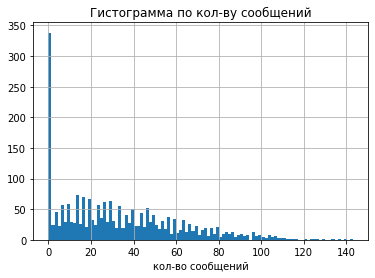

In [61]:
# Построение гистограммы по количеству сообщений
smart['message_amount'].hist(bins=100)
plt.title('Гистограмма по кол-ву сообщений')
plt.xlabel('кол-во сообщений')
plt.show()

Значительная часть клиентов тарифа `Smart` не пользуется отправкой сообщений. Рассмотрим распределение данных по клиентам, которые пользуются сообщениями.

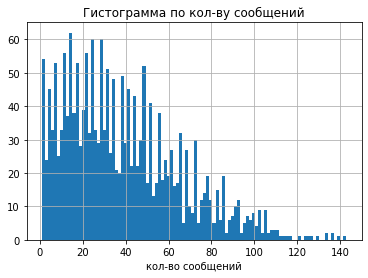

In [62]:
# Построение гистограммы по количеству сообщений без 0 значений
smart_message = smart.query('message_amount > 0')
smart_message['message_amount'].hist(bins=100)
plt.title('Гистограмма по кол-ву сообщений')
plt.xlabel('кол-во сообщений')
plt.show()

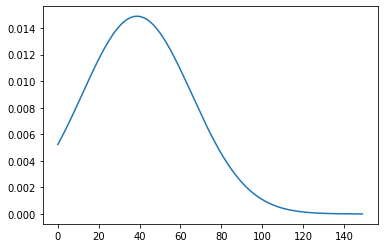

In [63]:
# Среднее количество сообщений
smart_message_mean = smart_message['message_amount'].mean()

# Расчет дисперсии по выборке
variance_smart_message = np.var(smart_message['message_amount'], ddof=1)

# Стандартное отклонение равно квадратному корню из дисперсии 
st_deviation_message = np.sqrt(variance_smart_message)

# Построение графика нормального распределения
plt.plot(st.norm.pdf(range(0, 150),smart_message_mean, st_deviation_message))
plt.show() 

**Описание распределения:** данные по количеству сообщений имеют нормальное распределение с положительной скошенностью. `Среднее количество сообщений в месяц составляет 39шт` (медианное 34шт), дисперсия = 718, стандартное отклонение = 27.

#### Интернет трафик

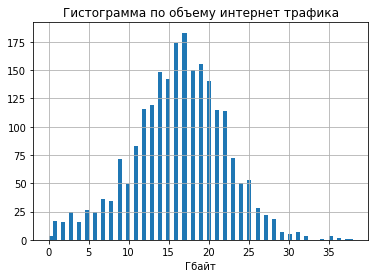

In [64]:
# Округление трафика до Гб в большую сторону, корреткировка типа данных и построение гистограммы по использанному объему интернет трафика
np.ceil(smart.loc[:,'mb_used_month'] / 1024).astype(int).hist(bins=75)
plt.title('Гистограмма по объему интернет трафика')
plt.xlabel('Гбайт')
plt.show()

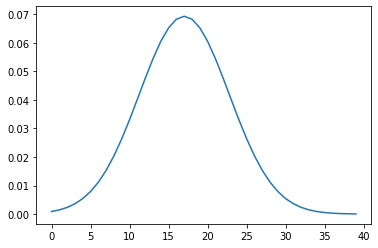

In [65]:
# Средний объем трафика
smart_internet_mean = np.ceil(smart.loc[:,'mb_used_month'] / 1024).astype(int).median()

# Расчет дисперсии по выборке
variance_smart_internet = np.var(np.ceil(smart.loc[:,'mb_used_month'] / 1024).astype(int), ddof=1)

# Стандартное отклонение равно квадратному корню из дисперсии 
st_deviation_internet = np.sqrt(variance_smart_internet)

# Построение графика нормального распределения
plt.plot(st.norm.pdf(range(0, 40),smart_internet_mean, st_deviation_internet))
plt.show() 

**Описание распределения:** данные по объему трафика имеют нормальное распределение с небольшой отрицательной скошенностью. `Средний объем используемого интернет трафика в месяц составляет 16.3Гб` (медианное 17.0Мб), дисперсия = 31.13, стандартное отклонение = 5.756.

### Тариф ultra

In [66]:
# Срез df по тарифу ultra и наличию выручки
ultra = df.query('tariff == "ultra" and revenue > 0')

#### Минуты разговора

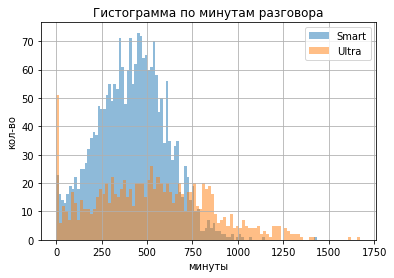

In [67]:
# Построение гистограммы по минутам разговора + сравнение с тарифом Smart
smart['calls_time'].hist(bins=100, alpha = 0.5, label='Smart')
ultra['calls_time'].hist(bins=100, alpha = 0.5, label='Ultra')
plt.title('Гистограмма по минутам разговора')
plt.legend(loc='best')
plt.xlabel('минуты')
plt.ylabel('кол-во')
plt.show()

Часть клиентов тарифа Ultra не используют телефон для разговоров.

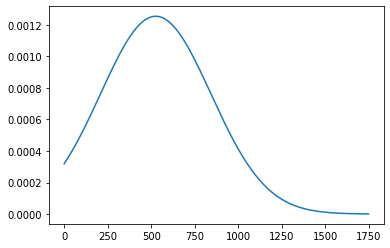

In [68]:
# Среднее количество минут разговора
ultra_calls_mean = ultra['calls_time'].mean()

# Расчет дисперсии по выборке
variance_ultra_calls = np.var(ultra['calls_time'], ddof=1)

# Стандартное отклонение равно квадратному корню из дисперсии 
st_deviation_calls = np.sqrt(variance_ultra_calls)

# Построение графика нормального распределения
plt.plot(st.norm.pdf(range(0, 1750), ultra_calls_mean, st_deviation_calls))
plt.show() 

**Описание распределения:** данные по минутам разговора имеют нормальное распределение с небольшой положительной скошенностью. `Среднее время разговора в месяц составляет 526 минут` (медианное 518 мин.), дисперсия = 101052, стандартное отклонение = 318.

#### Количество сообщений

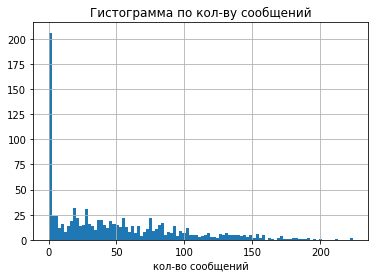

In [69]:
# Построение гистограммы по количеству сообщений
ultra['message_amount'].hist(bins=100)
plt.title('Гистограмма по кол-ву сообщений')
plt.xlabel('кол-во сообщений')
plt.show()

Значительная часть клиентов тарифа `Ultra` не пользуется отправкой сообщений. Рассмотрим распределение данных по клиентам, которые пользуются сообщениями.

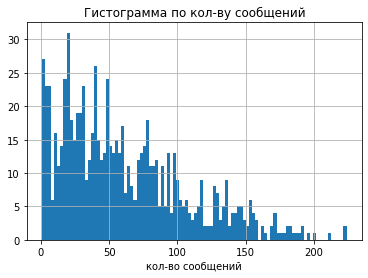

In [70]:
# Построение гистограммы по количеству сообщений без 0 значений
ultra_message = ultra.query('message_amount > 0')
ultra_message['message_amount'].hist(bins=100)
plt.title('Гистограмма по кол-ву сообщений')
plt.xlabel('кол-во сообщений')
plt.show()

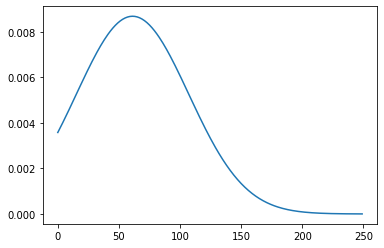

In [71]:
# Среднее количество сообщений
ultra_message_mean = ultra_message['message_amount'].mean()

# Расчет дисперсии по выборке
variance_ultra_message = np.var(ultra_message['message_amount'], ddof=1)

# Стандартное отклонение равно квадратному корню из дисперсии 
st_deviation_message = np.sqrt(variance_ultra_message)

# Построение графика нормального распределения
plt.plot(st.norm.pdf(range(0, 250),ultra_message_mean, st_deviation_message))
plt.show() 

**Описание распределения:** данные по количеству сообщений имеют нормальное распределение с положительной скошенностью. `Среднее количество сообщений в месяц составляет 61шт` (медианное 51шт), дисперсия = 2110, стандартное отклонение = 46.

#### Интернет трафик

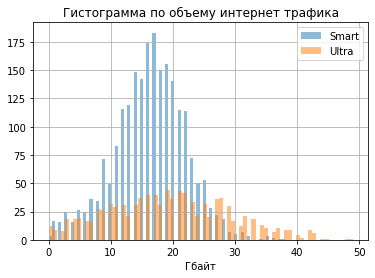

In [72]:
# Округление трафика до Гб в большую сторону, корреткировка типа данных и построение гистограммы по использанному объему интернет трафика
np.ceil(smart.loc[:,'mb_used_month'] / 1024).astype(int).hist(bins=75, alpha = 0.5, label='Smart')
np.ceil(ultra.loc[:,'mb_used_month'] / 1024).astype(int).hist(bins=75, alpha = 0.5, label='Ultra')
plt.title('Гистограмма по объему интернет трафика')
plt.xlabel('Гбайт')
plt.legend(loc='best')
plt.show()

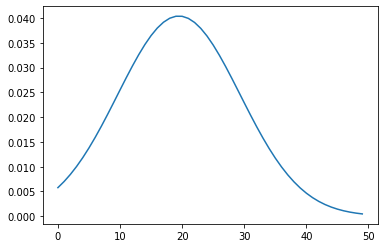

In [73]:
# Средний объем трафика
ultra_internet_mean = np.ceil(ultra.loc[:,'mb_used_month'] / 1024).astype(int).mean()

# Расчет дисперсии по выборке
variance_ultra_internet = np.var(np.ceil(ultra.loc[:,'mb_used_month'] / 1024).astype(int), ddof=1)

# Стандартное отклонение равно квадратному корню из дисперсии 
st_deviation_internet = np.sqrt(variance_ultra_internet)

# Построение графика нормального распределения
plt.plot(st.norm.pdf(range(0, 50),ultra_internet_mean, st_deviation_internet))
plt.show() 

**Описание распределения:** данные по объему трафика имеют нормальное распределение с небольшой положительной скошенностью. `Средний объем используемого интернет трафика в месяц составляет 19.5Гб` (медианное 19.0Гб), дисперсия = 97.38, стандартное отклонение = 4.413.

## Проверка гипотез

### Cредняя выручка пользователей тарифов «Смарт» и «Ультра» различаются

**Нулевая гипотеза:** средняя выручка пользователей тарифа "Смарт" равна А.

**Альтернативная гипотеза:** средняя выручка пользователей тарифа "Ультра" не равна А.

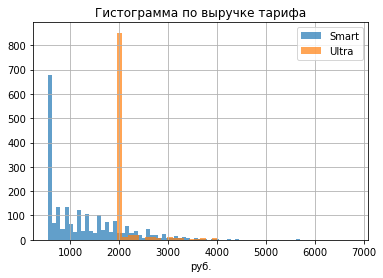

In [74]:
# Построение гистограммы по выручке
smart['revenue'].hist(bins=75, alpha=0.7, label='Smart')
ultra['revenue'].hist(bins=25, alpha=0.7, label='Ultra')
plt.title('Гистограмма по выручке тарифа')
plt.xlabel('руб.')
plt.legend(loc='best')
plt.show()

In [75]:
# Средняя месячная выручка по тарифу Smart
smart['revenue'].mean()

1289.6417040358745

In [76]:
# Средняя месячная выручка по тарифу Ultra
ultra['revenue'].mean()

2070.030425963489

In [77]:
# Абсолютная выручка по тарифу Smart
smart['revenue'].sum()

2875901.0

In [78]:
# Абсолютная выручка по тарифу Ultra
ultra['revenue'].sum()

2041050.0

Примечание: основная выручка по двум тарифам формируется за счет абонентской платы, но клиенты тарифа Ultra реже превышают бесплатные лимиты в отличии от клиентов с тарифом Smart. При том, что тарифом Ultra пользуется всего 30%, доля выручки от общего значения составляет 42%.

In [79]:
# Размер выборки тарифа Smart
len(smart.index)

2230

In [80]:
# Размер выборки тарифа Ultra
len(ultra.index)

986

In [81]:
# т.к. выборки разного размера используется equal_var = False
results = st.ttest_ind(smart['revenue'], ultra['revenue'], equal_var = False)

# критический уровень статистической значимости 
alpha = .05 

print('p-значение:', results.pvalue)

if results.pvalue < alpha:
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу") 

p-значение: 1.927011394420941e-250
Отвергаем нулевую гипотезу


**Вывод:** `Выручка пользователей тарифов «Смарт» и «Ультра» различаются`, т.к. вероятность получить среднее значение выручки тарифа Smart в выборке тарифа Ultra крайне мала (нулевая гипотеза отвергается). 

### Средняя выручка пользователей из Москвы отличается от выручки пользователей из других регионов

**Нулевая гипотеза:** средняя выручка пользователей из Москвы равна А.

**Альтернативная гипотеза:** средняя выручка пользователей не из Москвы не равна А.

In [82]:
# Срез df по тарифу городу и наличию выручки
moscow = df.query('city == "Москва" and revenue > 0')

# Срез df по тарифу городу и наличию выручки
citys = df.query('city != "Москва" and revenue > 0')

In [83]:
# Средняя месячная выручка по Москве
moscow['revenue'].mean()

1546.7135842880523

In [84]:
# Средняя месячная выручка по другим городам
citys['revenue'].mean()

1524.7251439539348

In [85]:
# Размер выборки по Москве
len(moscow.index)

611

In [86]:
# Размер выборки по другим городам
len(citys.index)

2605

In [87]:
# т.к. выборки разного размера используется equal_var = False
results = st.ttest_ind(moscow['revenue'], citys['revenue'], equal_var = False)

# критический уровень статистической значимости 
alpha = .05 

print('p-значение:', results.pvalue)

if results.pvalue < alpha:
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу") 

p-значение: 0.5216952110000278
Не получилось отвергнуть нулевую гипотезу


**Вывод:** `Средняя выручка пользователей из Москвы не отличается от выручки пользователей из других регионов`, т.к. вероятность получить среднее значение выручки по Москве в выборке из других городов составляет 52% (нулевая гипотеза не может быть отвергнута). 

## Общий вывод

**Входные данные:**
* Есть ***несоответствия в типах данных***: churn_date, reg_date, call_date, duration, message_date, session_date;
* В источнике данных с информацией об интернет-сессиях есть ***столбец дублирующий индексацию Unnamed: 0***, при последующих выгрузках желательно сохранять файлы с данными без индекса, используя index=False.

**Средние значения в месяц по тарифу Smart:**
* Время разговора - 418 минут
* Количество сообщений - 39 шт.
* Объем используемого интернет трафика - 16.3 Гб
* Выручка - 1 290 руб.

**Средние значения в месяц по тарифу Ultra:**
* Время разговора - 526 минут
* Количество сообщений - 61 шт.
* Объем используемого интернет трафика - 19.5 Гб
* Выручка - 2 070 руб.

**Проверенные гипотезы:**
* Выручка пользователей тарифов «Смарт» и «Ультра» различаются
* Средняя выручка пользователей из Москвы не отличается от выручки пользователей из других регионов

**Лучший тариф с точки зрения выручки - Ultra** (за счет высокой абонентской платы генерирует больше выручки на 1 клиента, чем тариф Smart с низкой абонентской платой и большей частотой превышения лимитов).

## Чек-лист готовности проекта

- [x]  открыты файлы
- [x]  файлы изучены (выведены первые строки, метод `info()`)
- [x]  определены пропущенные значения
- [x]  есть пояснение, какие пропущенные значения обнаружены
- [x]  изменены типы данных
- [x]  есть пояснение, в каких столбцах изменены типы и почему
- [x]  посчитано и добавлено в таблицу: количество сделанных звонков и израсходованных минут
- [x]  посчитано и добавлено в таблицу: количество отправленных сообщений
- [x]  посчитано и добавлено в таблицу: объем израсходованного трафика
- [x]  посчитано и добавлено в таблицу: помесячная выручка с каждого пользователя
- [x]  построены и описаны гистограммы по количеству минут, сообщений и интернет трафику для всех тарифов
- [x]  построены и описаны гистограммы по выручке
- [x]  проверена гипотеза: средняя выручка пользователей тарифов «Смарт» и «Ультра» различаются
- [x]  проверена гипотеза: средняя выручка пользователей из Москвы отличается от выручки пользователей из других регионов
- [x]  в каждом этапе есть выводы
- [x]  есть общий вывод